In [6]:
from PIL import Image
import torch.optim as optim
from tqdm import tqdm

In [7]:
import torch
import torch.nn as nn

#Convolutional Neural Network class that inherits from nn.Module
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            # Layer 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(4, stride=4),
            
            # Layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            
            # Layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(8, stride=8),
            
            # Flatten
            nn.Flatten(1),
            
            # Classifier section
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 148),
            nn.ReLU(),
            # Final output layer
            nn.Linear(148, 2)
        )

    def forward(self, x):
        x = self.features(x)
        return x


In [8]:
from torch.utils.data import Dataset
import os
from glob import glob
import natsort
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

# split the train_dataset, train_dataset_lables, test_dataset, test_dataset_lables and appends each of them individually in a list
class CoreDataset(Dataset):
    def __init__(self, folder_paths, transform=None, train=True):

        subset_numbers = {
            'I': [1, 7, 8, 9, 36, 37],
            'II': [2, 5, 10, 11, 12, 13, 15, 39, 40, 41, 42, 44],
            'III': [3, 6, 14, 16, 17, 19, 20, 43, 45, 46, 48, 49],
            'IV': [18, 21, 22, 23, 24, 25, 26, 47, 50, 51, 52, 53, 54, 55, 38],
            'V': [4, 27, 28, 29, 30, 31, 32, 33, 34, 35, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
        }
        i = 0
        self.folder_paths = folder_paths
        self.transform = transform
        self.train = train
        self.train_dataset = []
        self.test_dataset = []
        self.train_dataset_lables = []
        self.test_dataset_lables = []
        self.file_names = []
        self.file_path = []
        label_to_value = {"I": 0, "II": 1, "III": 2,"IV": 3,"V": 4}
        for folder_path in folder_paths:
            #print(folder_path)
            for filename in natsort.natsorted(glob(os.path.join(folder_path, '*'))):
                    self.file_names.append((filename.split('/')[-1]).split('\\')[-1])
                    self.file_path.append(filename)
            #print(file_path)
            for i in range(len(self.file_names)):
                person_number = int(''.join(filter(str.isdigit, self.file_names[i])))
                for subset_name, subset_numbers_list in subset_numbers.items():
                    if label_to_value[subset_name] in (0, 2, 3, 4) and (self.train==True):
                        #print("train")
                        self.train_dataset.append(self.file_path[i])
                        if "6P" in str(folder_path):
                            self.train_dataset_lables.append(0)
                        elif "7P" in str(folder_path):
                            self.train_dataset_lables.append(1)
                    elif label_to_value[subset_name] == 1 and (self.train==False):
                        self.test_dataset.append(self.file_path[i])
                        if "6P" in str(folder_path):
                            self.test_dataset_lables.append(0)
                        elif "7P" in str(folder_path):
                            self.test_dataset_lables.append(1)
            
        #return train_dataset, train_dataset_lables, test_dataset, test_dataset_lables
    def __len__(self):
        if self.train == True :
            return len(self.train_dataset)
        else: 
            return len(self.test_dataset)
    def __getitem__(self, idx):
        if self.train:
            image = Image.open(self.train_dataset[idx]).convert("L")
            label = self.train_dataset_lables[idx]
        else:
            image = Image.open(self.test_dataset[idx]).convert("L")
            label = self.test_dataset_lables[idx]

        if self.transform is not None:
            image = self.transform(image)

        return image, label


# Data Augmentation
class SharpenTransform:
    def __init__(self):
        self.sharpening_kernel = torch.tensor([
            [-1, -1, -1],
            [-1,  9, -1],
            [-1, -1, -1]
        ]).float().unsqueeze(0).unsqueeze(0) 

    def __call__(self, x):
        x = x.unsqueeze(0) 
        padding = nn.ReflectionPad2d(1)  
        x = padding(x)
        for i in range(x.size(1)):
            x[0, i] = torch.nn.functional.conv2d(x[0, i].unsqueeze(0).unsqueeze(0), self.sharpening_kernel, padding=1).squeeze(0).squeeze(0)
        return x.squeeze(0)  

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5), 
    transforms.RandomRotation(degrees=15),
    SharpenTransform(),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    #transforms.RandomPerspective(distortion_scale=0.5, p=0.5)
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)), #reduce accuracy

])


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 0.001
epochs = 100
folder_paths = ["C:/Users/pariya/OneDrive/Desktop/FacePrediction/YaleB/B06P00", "C:/Users/pariya/OneDrive/Desktop/FacePrediction/YaleB/B07P00"]


core_model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(core_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.001)
train_dataset = CoreDataset(folder_paths, transform=transform, train = True)
test_dataset = CoreDataset(folder_paths, transform=transform, train = False)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)


In [10]:
import plotly.graph_objects as go
import plotly.offline as pyo

# train the model and plot the loss
train_losses = []

for epoch in range(epochs):
    core_model.train()
    total_train_loss = 0.0
    for inputs, labels in tqdm(train_dataloader, leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = core_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    average_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(average_train_loss)


# plot the loss
trace_train = go.Scatter(
    x=list(range(1, epochs + 1)),
    y=train_losses,
    mode='lines+markers',
    name='Train Loss'
)

layout = go.Layout(
    title='Training Losses Over Epochs',
    xaxis=dict(title='Epoch'),
    yaxis=dict(title='Loss'),
    hovermode='closest'
)
fig = go.Figure(data=[trace_train], layout=layout)
pyo.iplot(fig)

 10%|█         | 10/98 [00:00<00:06, 13.36it/s]

In [ ]:
import torch
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from tqdm import tqdm
# test the model and print the important metrics
core_model.eval()

predictions = []
labels = []


with torch.no_grad():
    for test_inputs, test_labels in tqdm(test_dataloader, leave=False):
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = core_model(test_inputs)
        _, predicted = torch.max(test_outputs, 1)
        predictions.append(predicted.detach())
        labels.append(test_labels.detach())


predictions = torch.cat(predictions).cpu()
labels = torch.cat(labels).cpu()

f1 = f1_score(labels, predictions, average='weighted')
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions, average='weighted')
recall = recall_score(labels, predictions, average='weighted')
conf_matrix = confusion_matrix(labels, predictions)

# Metrics
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Confusion Matrix:\n{conf_matrix}")


F1 Score: 0.69
Accuracy: 0.69
Precision: 0.71
Recall: 0.69
Confusion Matrix:
[[42 23]
 [38 92]]


In [ ]:
import torch
import plotly.graph_objects as go
import plotly.offline as pyo
from tqdm import tqdm
# compare the trainloss and testloss for each epoch

train_losses = []
test_losses = []

best_test_loss = float('inf')

for epoch in range(epochs):
    core_model.train()
    total_train_loss = 0.0
    total_test_loss = 0.0

    for inputs, labels in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs} - Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = core_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    core_model.eval() 
    with torch.no_grad():
        for inputs, labels in tqdm(test_dataloader, leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = core_model(inputs)
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()

    average_train_loss = total_train_loss / len(train_dataloader)
    average_test_loss = total_test_loss / len(test_dataloader)
    train_losses.append(average_train_loss)
    test_losses.append(average_test_loss)
    if average_test_loss < best_test_loss:
        best_test_loss = average_test_loss
        torch.save(core_model.state_dict(), 'best_model.pth')


    #print(f"Epoch [{epoch + 1}/{epochs}] - Train Loss: {average_train_loss:.4f}, Test Loss: {average_test_loss:.4f}")
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, epochs+1)), y=train_losses, mode='lines+markers', name='Train Loss'))
fig.add_trace(go.Scatter(x=list(range(1, epochs+1)), y=test_losses, mode='lines+markers', name='Test Loss'))
fig.update_layout(title='Training and Testing Loss Over Epochs', xaxis_title='Epoch', yaxis_title='Loss', legend_title='Loss Type')
pyo.iplot(fig)


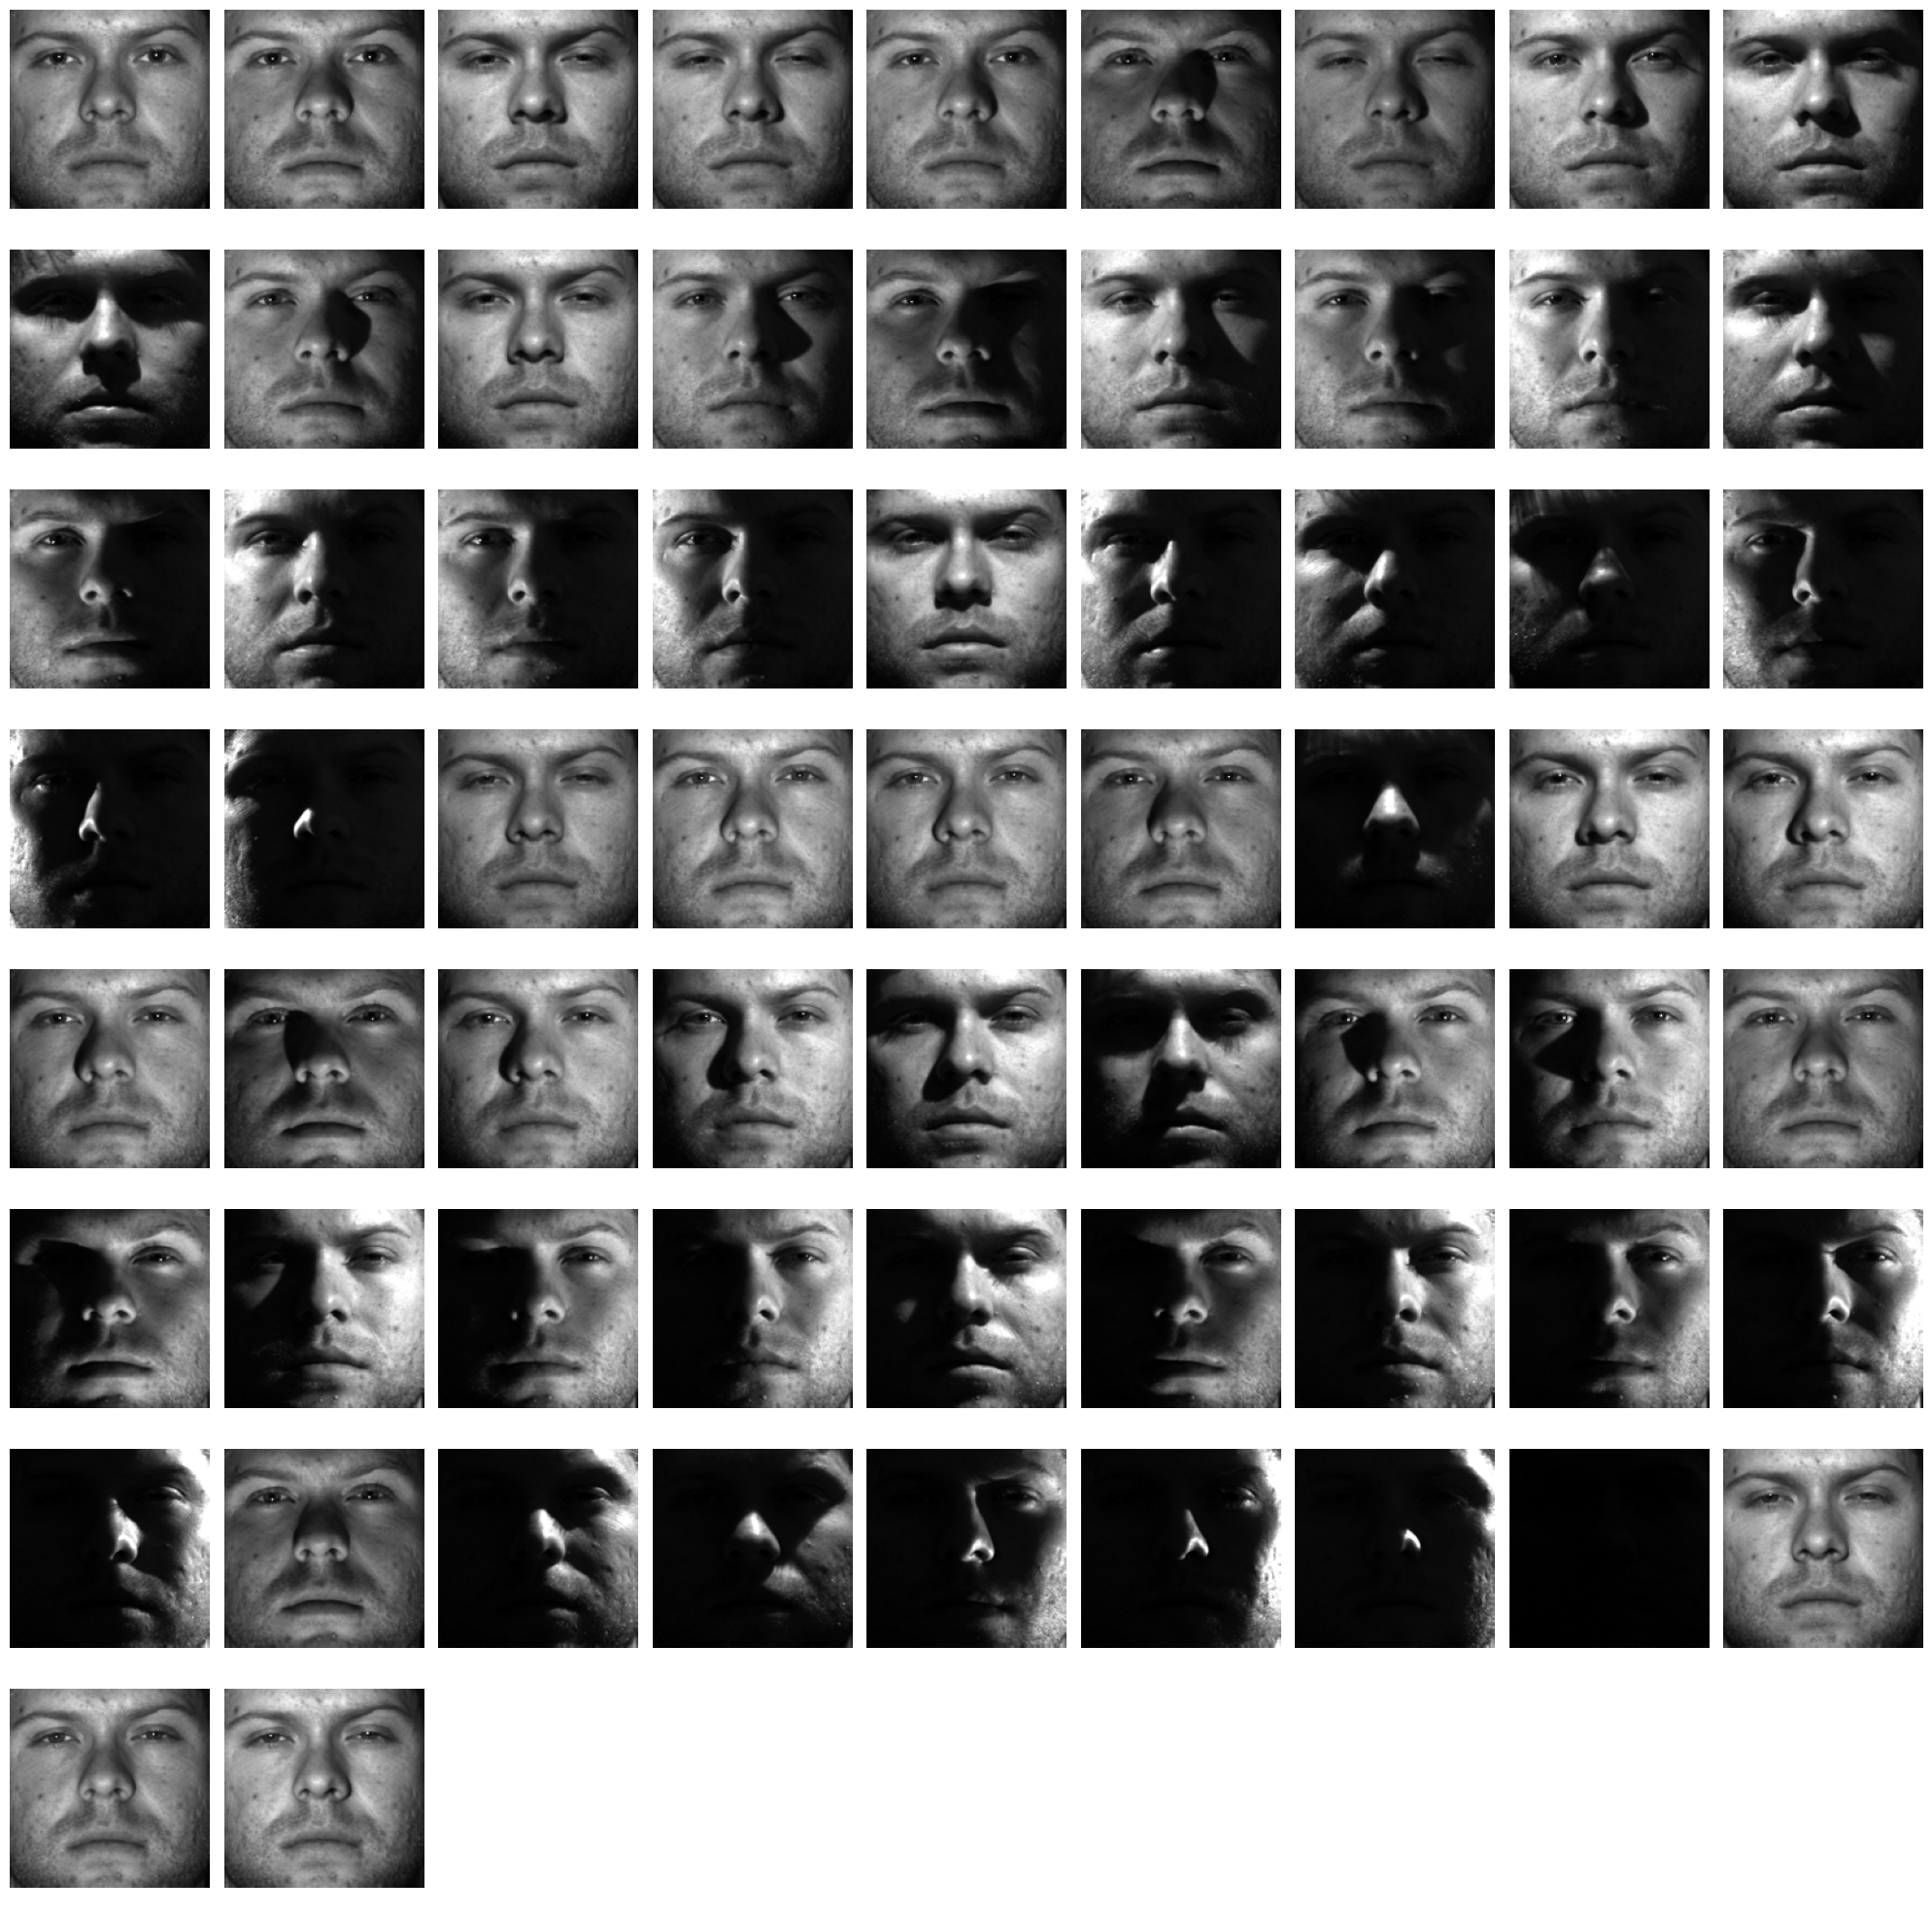

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# plot the all images of one person
image_files = [f for f in os.listdir('YaleB/B01P00') if f.endswith('.tif')]  # Adjust the extension as needed
images = [Image.open(os.path.join('YaleB/B01P00', file)).convert('RGB') for file in image_files]  # Convert to RGB


img_width, img_height = images[0].size


cols = 9
rows = len(images) // cols + (1 if len(images) % cols else 0)


fig, axs = plt.subplots(rows, cols, figsize=(20, 20))  

for i, img in enumerate(images):
    ax = axs[i // cols, i % cols]
    ax.imshow(img, aspect='equal')
    ax.axis('off')

# Hide any unused subplots
for i in range(len(images), rows * cols):
    axs[i // cols, i % cols].axis('off')

plt.tight_layout()
plt.show()
